## 라이브러리 임포트

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import gc

import matplotlib.pyplot as plt
import seaborn as sns

import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
import keras
import tensorflow as tf
import keras.backend as K
from keras import optimizers, callbacks
from keras.layers import Dense, Concatenate, Activation, Add, BatchNormalization, Dropout
from keras.models import Input, Model, Sequential, load_model
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import random

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
# tf.config.set_visible_devices(tf.config.list_physical_devices('CPU'))
# logical_devices = tf.config.list_logical_devices('CPU')
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = ""
# tf.config.experimental.set_visible_devices([], 'GPU')
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)

def mape(y_true, y_pred):
    return 100*np.mean((np.abs(y_true-y_pred)/y_true))

def mish(x):
    return x*K.tanh(K.softplus(x))

def decay(epochs):
    init = 1e-3
    drop = 25
    ratio = 0.9
    return max(5e-5, (init * (ratio ** (epochs//drop))))    

es = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
lrs = callbacks.LearningRateScheduler(decay, verbose=0)


Using TensorFlow backend.


In [3]:
def custom_loss(true, pred):
    ph = np.array([88.05, 88.18, 87.67, 84.45, 87.91, 88.99, 90.31, 92.77])
    true = true[:,10:18]
    pred = pred[:,10:18]
    
    prior = np.abs(true - pred)
    perfect = np.zeros_like(prior)
    prior = 0.08*113 - prior
    prior = np.where(prior<0, 0, prior)
    score = np.sum(prior * ph)
    
    perfect = 0.08*113 - perfect
    perfect = np.where(perfect<0, 0, perfect)
    perfect = np.sum(perfect * ph)
#     return score
    return -score/perfect+1


def custom_loss_nn(true, pred):
    ph = np.array([88.05, 88.18, 87.67, 84.45, 87.91, 88.99, 90.31, 92.77])
    true = true[:,10:18]*113
    pred = pred[:,10:18]*113
    
    prior = K.abs(true - pred)
    perfect = K.zeros_like(prior)
    prior = 0.08*113 - prior
    prior = tf.where(prior<0., 0., prior)
    score = K.sum(prior * ph)
    
    perfect = 0.08*113 - perfect
    perfect = tf.where(perfect<0., 0., perfect)
    perfect = K.sum(perfect * ph)
#     return score
    return -score/perfect+1

## 데이터 전처리

In [4]:
data = pd.read_csv('./data/data1.csv')
df_w = pd.read_csv('./data/weather.csv')
df_w['일교차'] = df_w['일최고기온'] - df_w['일최저기온']

In [5]:
due_cols = list(df_w.columns[df_w.columns.str.contains('습도')])
rp_cols = list(df_w.columns[df_w.columns.str.contains('강수확률')])

wd_cols = list(df_w.columns[df_w.columns.str.contains('풍향')])

sky_cols = list(df_w.columns[df_w.columns.str.contains('하늘')])
rt_cols = list(df_w.columns[df_w.columns.str.contains('강수형태')])

wp_cols = list(df_w.columns[df_w.columns.str.contains('풍속')])

pre_cols = due_cols + rp_cols + wd_cols + sky_cols + rt_cols
scale_cols = [c for c in df_w.columns if c not in pre_cols]

# wp_cols = df_w.columns[df_w.columns.str.contains('풍속')]

In [6]:
for c in due_cols + rp_cols:
    df_w[c] /= 100
    
# for c in wd_cols:
#     df_w[c] /= 360

In [7]:
# 비가 오거나 오지 않음
df_w[rt_cols] = np.where(df_w[rt_cols]==0, 0, 1)

In [8]:
def wp_cat(x):
    if x < 4:
        return 0
    elif x < 9:
        return 1
    elif x < 14:
        return 2
    else:
        return 3


In [12]:
df_w.drop(sky_cols+wd_cols, axis=1, inplace=True) # wp_cat_cols

In [51]:
scale_cols

['3시간기온_9',
 '3시간기온_12',
 '3시간기온_15',
 '3시간기온_18',
 '3시간기온_21',
 '6시간강수량_9',
 '6시간강수량_12',
 '6시간강수량_15',
 '6시간강수량_18',
 '6시간강수량_21',
 '일최고기온',
 '일최저기온',
 '풍속_9',
 '풍속_12',
 '풍속_15',
 '풍속_18',
 '풍속_21',
 '일교차']

In [13]:
scaler = MinMaxScaler()
scaler.fit(df_w[scale_cols])
df_w[scale_cols] = scaler.transform(df_w[scale_cols])
df_w.head()

,3시간기온_9,3시간기온_12,3시간기온_15,3시간기온_18,3시간기온_21,6시간강수량_9,6시간강수량_12,6시간강수량_15,6시간강수량_18,6시간강수량_21,...,습도_18,습도_21,일최고기온,일최저기온,풍속_9,풍속_12,풍속_15,풍속_18,풍속_21,일교차
0,0.820513,0.810811,0.777778,0.756757,0.763158,0.0,0.0,0.0,0.0,0.0,...,0.85,0.85,0.87500,0.783784,0.140244,0.043011,0.015544,0.014218,0.013453,0.555556
1,0.846154,0.810811,0.777778,0.756757,0.763158,0.0,0.0,0.0,0.0,0.0,...,0.90,0.90,0.87500,0.783784,0.140244,0.043011,0.010363,0.014218,0.013453,0.555556
2,0.846154,0.864865,0.833333,0.810811,0.789474,0.0,0.0,0.0,0.0,0.0,...,0.85,0.90,0.90625,0.810811,0.079268,0.053763,0.031088,0.028436,0.017937,0.555556
3,0.897436,0.864865,0.833333,0.810811,0.789474,0.0,0.0,0.0,0.0,0.0,...,0.85,0.85,0.93750,0.810811,0.146341,0.064516,0.025907,0.018957,0.008969,0.611111
4,0.948718,0.918919,0.888889,0.837838,0.842105,0.0,0.0,0.0,0.0,0.0,...,0.70,0.80,1.00000,0.810811,0.067073,0.064516,0.041451,0.037915,0.031390,0.722222


In [14]:
df_w.columns

Index(['3시간기온_9', '3시간기온_12', '3시간기온_15', '3시간기온_18', '3시간기온_21', '6시간강수량_9',
       '6시간강수량_12', '6시간강수량_15', '6시간강수량_18', '6시간강수량_21', '강수형태_9', '강수형태_12',
       '강수형태_15', '강수형태_18', '강수형태_21', '강수확률_9', '강수확률_12', '강수확률_15',
       '강수확률_18', '강수확률_21', '습도_9', '습도_12', '습도_15', '습도_18', '습도_21',
       '일최고기온', '일최저기온', '풍속_9', '풍속_12', '풍속_15', '풍속_18', '풍속_21', '일교차'],
      dtype='object')

In [15]:
data['time'] = np.repeat(range(10584), 4)
data.groupby('time').sum()['energy'][:24].values

array([0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 4.243131e-01, 3.052172e+00, 6.539460e+00,
       1.514969e+01, 2.960223e+01, 4.734645e+01, 6.337880e+01,
       6.210080e+01, 4.484939e+01, 4.704503e+01, 4.956060e+01,
       2.854754e+01, 2.949115e+01, 1.192320e+01, 1.325924e+00,
       1.000000e-02, 0.000000e+00, 0.000000e+00, 0.000000e+00])

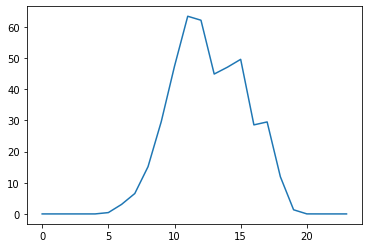

In [16]:
plt.plot(data.groupby('time').sum()['energy'][:24])

In [17]:
X = []
for i in range(0, 10584, 24):
    X.append(data.groupby('time').sum()['energy'][i:i+24].values)
    
X = np.array(X)
X.shape

(441, 24)

In [18]:
X[:,10:18]

array([[47.34645, 63.3788 , 62.1008 , ..., 49.5606 , 28.54754, 29.49115],
       [62.3199 , 67.9998 , 77.9868 , ..., 64.0896 , 48.9885 , 28.52915],
       [66.2824 , 68.9158 , 66.1128 , ..., 51.2706 , 29.53954, 23.96415],
       ...,
       [31.128  , 36.5    , 46.15   , ..., 13.74   ,  7.888  ,  1.231  ],
       [21.708  , 22.385  , 22.863  , ..., 16.403  ,  7.584  ,  2.517  ],
       [82.082  , 86.474  , 89.483  , ..., 44.002  , 24.006  , 14.6    ]])

In [19]:
target = X[1:]
wX = df_w.iloc[:-1,:].values
data = np.hstack([X[:-1]/113, wX])

In [20]:
target.shape, data.shape

((440, 24), (440, 57))

In [21]:
# data = data[:,10:18]
# target = target[:,10:18]

## 비교를 위한 베이스라인 모형

In [22]:
data[0]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.75498319e-03, 2.70103717e-02, 5.78713274e-02,
       1.34068053e-01, 2.61966637e-01, 4.18995133e-01, 5.60874336e-01,
       5.49564602e-01, 3.96897257e-01, 4.16327699e-01, 4.38589381e-01,
       2.52633097e-01, 2.60983628e-01, 1.05515044e-01, 1.17338407e-02,
       8.84955752e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       8.20512821e-01, 8.10810811e-01, 7.77777778e-01, 7.56756757e-01,
       7.63157895e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.00000000e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.50000000e-01, 6.00000000e-01, 8.00000000e-01, 8.50000000e-01,
       8.50000000e-01, 8.75000000e-01, 7.83783784e-01, 1.40243911e-01,
       4.30107504e-02, 1.55440415e-02, 1.42180088e-02, 1.34529148e-02,
      

In [23]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=SEED)

In [24]:
from sklearn.model_selection import train_test_split

tr_X, val_X, tr_y, val_y = train_test_split(data, target, test_size=0.15, random_state=SEED)

In [25]:
# val_y = val_y.astype('float32')

In [26]:
rf.fit(tr_X, tr_y)

RandomForestRegressor(random_state=42)

In [27]:
from sklearn.metrics import mean_absolute_error as mae

mae(val_y, rf.predict(val_X))

5.499808377425943

In [28]:
custom_loss(val_y, rf.predict(val_X))

0.7486968113240531

## 메인 모델

In [31]:
from keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import KFold

In [32]:
def Denseblock(n, activation=mish, bn=False):
    def f(x):
        x = Dense(n)(x)
        if bn:
            x = BatchNormalization()(x)
        x = Activation(activation)(x)
        return x
    return f

In [33]:
class GAN:
    def __init__(self, y_shape, x_shape): # latent = c_shape
        # data structure
        self.y_shape = y_shape
        self.x_shape = x_shape
        
        self.score = float('inf')
        self.mapes = []
        self.maes = []
        
        # build model
        self.gen = self.build_generator()
        self.disc = self.build_discriminator()
        
        inputs_x = Input(shape = self.x_shape[1:])
        inputs_y = Input(shape = self.y_shape[1:])
        
        pred_y = self.gen(inputs_x)

        self.disc.compile(optimizer=RMSprop(2e-4), loss='binary_crossentropy')
        self.disc.trainable = False

        valid = self.disc([inputs_x, pred_y])
        
        self.gan = Model([inputs_x, inputs_y], [valid, pred_y], name='GAN')
        self.gan.compile(optimizer=RMSprop(2e-4), loss=['binary_crossentropy']+['mae'], loss_weights=[1, 100])
        
    
    def build_generator(self):
        inputs = Input(shape = self.x_shape[1:])
        
        x = Denseblock(64)(inputs)
        x = Denseblock(32)(x)
#         x = Denseblock(32)(x)

        outputs = Dense(self.y_shape[1])(x)
        
        gen = Model(inputs, outputs, name='generator')
        
        return gen
    
    def build_discriminator(self):
        inputs_y = Input(shape = self.y_shape[1:])
        inputs_x = Input(shape = self.x_shape[1:])
        
        inputs = Concatenate()([inputs_x, inputs_y])
        
        x = Denseblock(64)(inputs)
        x = Denseblock(32)(x)
        
        outputs = Dense(1, activation='sigmoid')(x)
        
        disc = Model([inputs_x, inputs_y], outputs, name='discriminator')
        
        return disc

    def train(self, x, y, epochs=10, batch_size=1024):
        X = x.copy()
        Y = y.copy()

        n_ = self.y_shape[0]//batch_size
        
        for e in range(epochs):
#             idx = np.random.randint(0, self.y_shape[0], batch_size)
            kf = KFold(n_, shuffle=True)
            tot_disc_loss = 0
            tot_gan_loss = 0
            tot_mse_loss = 0
            tot_custom_loss = 0
            for _, idx in kf.split(x):
                real_label = np.zeros((len(idx), 1))
                fake_label = np.ones((len(idx), 1))
                train_x = x[idx]
                train_y = y[idx]

                fake = self.gen.predict(train_x)

                # train discriminator
                d_loss_real = self.disc.train_on_batch([train_x, train_y], real_label)
                d_loss_fake = self.disc.train_on_batch([train_x, fake], fake_label)
                d_loss = 0.5*np.add(d_loss_fake, d_loss_real)

                # train generator
                g_loss = self.gan.train_on_batch([train_x, train_y], [real_label] + [train_y])
                
                tot_disc_loss += d_loss
                tot_gan_loss += g_loss[1]
                tot_mse_loss += g_loss[2]
#                 tot_custom_loss += g_loss[3]
                
            print(f'iter:{e}')
            print(f'|disc_loss: {round(d_loss, 3)}, |gan_loss:, {round(g_loss[1], 3)} |mse_loss: {round(g_loss[2], 3)}')
#             print(tot_custom_loss)
            score = custom_loss(val_y, self.gen.predict(val_X))
            print('score:', score)
            print('#'*50)
            
            if self.score > score:
                self.score = score
                self.best_weights = self.gan.get_weights()
                
#             if e%200==1:
#                 self.gan.set_weights(self.best_weights)
#         self.gan.load_weights(f'./weights/gan_{self.score}.h5')
        self.gan.set_weights(self.best_weights)
            
            
    def evaluate(self, x, y, criterion):
        y_pred = self.gen.predict(x)
        y_pred = process_target(y_pred)
        res = criterion(y.values, y_pred)
        return res

In [34]:
gan = GAN(tr_y.shape, tr_X.shape)

In [35]:
tr_y.shape, tr_X.shape

((374, 24), (374, 57))

In [36]:
gan.train(tr_X, tr_y, batch_size=32, epochs=1000)

iter:0
|disc_loss: 0.205, |gan_loss:, 1.1369999647140503 |mse_loss: 18.98200035095215
score: 0.9046603538401823
##################################################
iter:1
|disc_loss: 0.157, |gan_loss:, 1.3839999437332153 |mse_loss: 18.71500015258789
score: 0.903816940986248
##################################################
iter:2
|disc_loss: 0.118, |gan_loss:, 1.6360000371932983 |mse_loss: 16.628000259399414
score: 0.902897887705302
##################################################
iter:3
|disc_loss: 0.083, |gan_loss:, 2.002000093460083 |mse_loss: 17.5939998626709
score: 0.9018072562956805
##################################################
iter:4
|disc_loss: 0.054, |gan_loss:, 2.433000087738037 |mse_loss: 19.445999145507812
score: 0.9005321904672126
##################################################
iter:5
|disc_loss: 0.042, |gan_loss:, 2.809000015258789 |mse_loss: 17.01300048828125
score: 0.8991065277631436
##################################################
iter:6
|disc_loss: 0.041, 

iter:52
|disc_loss: 0.13, |gan_loss:, 5.086999893188477 |mse_loss: 11.00100040435791
score: 0.8787780872733331
##################################################
iter:53
|disc_loss: 0.093, |gan_loss:, 4.61299991607666 |mse_loss: 10.24899959564209
score: 0.8774197692133446
##################################################
iter:54
|disc_loss: 0.368, |gan_loss:, 4.870999813079834 |mse_loss: 10.293999671936035
score: 0.8761025066993418
##################################################
iter:55
|disc_loss: 0.155, |gan_loss:, 4.934000015258789 |mse_loss: 10.678000450134277
score: 0.8762984079370468
##################################################
iter:56
|disc_loss: 0.088, |gan_loss:, 5.010000228881836 |mse_loss: 10.223999977111816
score: 0.8763549202801484
##################################################
iter:57
|disc_loss: 0.015, |gan_loss:, 5.011000156402588 |mse_loss: 9.144000053405762
score: 0.876134880877663
##################################################
iter:58
|disc_loss: 0.

iter:105
|disc_loss: 0.012, |gan_loss:, 5.034999847412109 |mse_loss: 7.011000156402588
score: 0.8734637953919724
##################################################
iter:106
|disc_loss: 0.009, |gan_loss:, 5.607999801635742 |mse_loss: 7.85699987411499
score: 0.873349863288863
##################################################
iter:107
|disc_loss: 0.008, |gan_loss:, 4.724999904632568 |mse_loss: 6.585000038146973
score: 0.8726476897708352
##################################################
iter:108
|disc_loss: 0.005, |gan_loss:, 5.327000141143799 |mse_loss: 7.050000190734863
score: 0.871338041326136
##################################################
iter:109
|disc_loss: 0.003, |gan_loss:, 5.60699987411499 |mse_loss: 6.993000030517578
score: 0.8701617174190103
##################################################
iter:110
|disc_loss: 0.117, |gan_loss:, 6.64900016784668 |mse_loss: 7.126999855041504
score: 0.8688000467231447
##################################################
iter:111
|disc_loss: 

iter:158
|disc_loss: 0.003, |gan_loss:, 6.0329999923706055 |mse_loss: 6.192999839782715
score: 0.8329996320055821
##################################################
iter:159
|disc_loss: 0.038, |gan_loss:, 6.96999979019165 |mse_loss: 6.261000156402588
score: 0.8322340227130147
##################################################
iter:160
|disc_loss: 0.002, |gan_loss:, 6.367000102996826 |mse_loss: 6.0929999351501465
score: 0.8324365239769642
##################################################
iter:161
|disc_loss: 0.052, |gan_loss:, 6.670000076293945 |mse_loss: 8.031000137329102
score: 0.8314439549489416
##################################################
iter:162
|disc_loss: 0.002, |gan_loss:, 7.394999980926514 |mse_loss: 6.258999824523926
score: 0.8312034060735748
##################################################
iter:163
|disc_loss: 0.005, |gan_loss:, 6.0970001220703125 |mse_loss: 5.817999839782715
score: 0.8305513113929801
##################################################
iter:164
|disc

iter:209
|disc_loss: 0.001, |gan_loss:, 7.866000175476074 |mse_loss: 6.183000087738037
score: 0.8168732646816419
##################################################
iter:210
|disc_loss: 0.061, |gan_loss:, 6.816999912261963 |mse_loss: 5.482999801635742
score: 0.8165539099350189
##################################################
iter:211
|disc_loss: 0.001, |gan_loss:, 7.331999778747559 |mse_loss: 5.232999801635742
score: 0.8164430847737885
##################################################
iter:212
|disc_loss: 0.017, |gan_loss:, 6.34499979019165 |mse_loss: 6.614999771118164
score: 0.8158985457575882
##################################################
iter:213
|disc_loss: 0.001, |gan_loss:, 7.053999900817871 |mse_loss: 6.906000137329102
score: 0.8163635443662839
##################################################
iter:214
|disc_loss: 0.001, |gan_loss:, 7.293000221252441 |mse_loss: 5.48799991607666
score: 0.8157977937128258
##################################################
iter:215
|disc_los

iter:260
|disc_loss: 0.001, |gan_loss:, 9.37600040435791 |mse_loss: 8.265000343322754
score: 0.8032702346761882
##################################################
iter:261
|disc_loss: 0.177, |gan_loss:, 8.972999572753906 |mse_loss: 5.816999912261963
score: 0.8022105072058561
##################################################
iter:262
|disc_loss: 0.007, |gan_loss:, 7.053999900817871 |mse_loss: 4.918000221252441
score: 0.8018169842916373
##################################################
iter:263
|disc_loss: 0.001, |gan_loss:, 7.889999866485596 |mse_loss: 6.486000061035156
score: 0.803527642388686
##################################################
iter:264
|disc_loss: 0.001, |gan_loss:, 8.187999725341797 |mse_loss: 5.633999824523926
score: 0.8022597050639377
##################################################
iter:265
|disc_loss: 0.006, |gan_loss:, 7.230000019073486 |mse_loss: 5.76800012588501
score: 0.7987584433438539
##################################################
iter:266
|disc_loss

iter:311
|disc_loss: 0.004, |gan_loss:, 7.196000099182129 |mse_loss: 5.605999946594238
score: 0.7876192176205616
##################################################
iter:312
|disc_loss: 0.011, |gan_loss:, 8.449000358581543 |mse_loss: 5.910999774932861
score: 0.7880152553531197
##################################################
iter:313
|disc_loss: 0.004, |gan_loss:, 7.198999881744385 |mse_loss: 6.243000030517578
score: 0.7873564600907998
##################################################
iter:314
|disc_loss: 0.001, |gan_loss:, 8.899999618530273 |mse_loss: 6.535999774932861
score: 0.786004749209567
##################################################
iter:315
|disc_loss: 0.001, |gan_loss:, 8.487000465393066 |mse_loss: 5.636000156402588
score: 0.785234564693122
##################################################
iter:316
|disc_loss: 0.0, |gan_loss:, 9.303000450134277 |mse_loss: 6.5970001220703125
score: 0.7848530441539505
##################################################
iter:317
|disc_loss

iter:362
|disc_loss: 0.004, |gan_loss:, 8.569000244140625 |mse_loss: 5.964000225067139
score: 0.7737752426370532
##################################################
iter:363
|disc_loss: 0.002, |gan_loss:, 7.9070000648498535 |mse_loss: 5.993000030517578
score: 0.7739550001372348
##################################################
iter:364
|disc_loss: 0.006, |gan_loss:, 7.807000160217285 |mse_loss: 6.4070000648498535
score: 0.7739622278132904
##################################################
iter:365
|disc_loss: 0.003, |gan_loss:, 8.013999938964844 |mse_loss: 6.033999919891357
score: 0.774323238582153
##################################################
iter:366
|disc_loss: 0.004, |gan_loss:, 6.7179999351501465 |mse_loss: 5.89300012588501
score: 0.7728875421790798
##################################################
iter:367
|disc_loss: 0.004, |gan_loss:, 7.427000045776367 |mse_loss: 5.271999835968018
score: 0.77310134718203
##################################################
iter:368
|disc_lo

iter:413
|disc_loss: 0.004, |gan_loss:, 6.748000144958496 |mse_loss: 6.684000015258789
score: 0.7642440296174762
##################################################
iter:414
|disc_loss: 0.008, |gan_loss:, 6.771999835968018 |mse_loss: 5.406000137329102
score: 0.7637339679065671
##################################################
iter:415
|disc_loss: 0.009, |gan_loss:, 6.980000019073486 |mse_loss: 4.550000190734863
score: 0.7641095579590071
##################################################
iter:416
|disc_loss: 0.04, |gan_loss:, 8.513999938964844 |mse_loss: 5.53000020980835
score: 0.7637039559703532
##################################################
iter:417
|disc_loss: 0.004, |gan_loss:, 7.179999828338623 |mse_loss: 5.504000186920166
score: 0.762715711400743
##################################################
iter:418
|disc_loss: 0.137, |gan_loss:, 8.88599967956543 |mse_loss: 5.593999862670898
score: 0.7630495708224438
##################################################
iter:419
|disc_loss:

iter:464
|disc_loss: 0.073, |gan_loss:, 8.204999923706055 |mse_loss: 5.270999908447266
score: 0.7582631913711987
##################################################
iter:465
|disc_loss: 0.018, |gan_loss:, 8.173999786376953 |mse_loss: 6.500999927520752
score: 0.7592539454123672
##################################################
iter:466
|disc_loss: 0.004, |gan_loss:, 7.526000022888184 |mse_loss: 6.206999778747559
score: 0.7585268064870407
##################################################
iter:467
|disc_loss: 0.008, |gan_loss:, 7.011000156402588 |mse_loss: 4.473999977111816
score: 0.7576767341974341
##################################################
iter:468
|disc_loss: 0.001, |gan_loss:, 8.755999565124512 |mse_loss: 5.607999801635742
score: 0.7575007096635606
##################################################
iter:469
|disc_loss: 0.002, |gan_loss:, 7.311999797821045 |mse_loss: 5.5289998054504395
score: 0.7576148374930403
##################################################
iter:470
|disc_

iter:515
|disc_loss: 0.008, |gan_loss:, 7.086999893188477 |mse_loss: 6.133999824523926
score: 0.747539163063885
##################################################
iter:516
|disc_loss: 0.002, |gan_loss:, 7.511000156402588 |mse_loss: 5.544000148773193
score: 0.7467833085939432
##################################################
iter:517
|disc_loss: 0.001, |gan_loss:, 8.343000411987305 |mse_loss: 4.831999778747559
score: 0.7464257443961864
##################################################
iter:518
|disc_loss: 0.132, |gan_loss:, 5.833000183105469 |mse_loss: 5.109000205993652
score: 0.7469775269085845
##################################################
iter:519
|disc_loss: 0.147, |gan_loss:, 8.743000030517578 |mse_loss: 5.5320000648498535
score: 0.7472655176960212
##################################################
iter:520
|disc_loss: 0.006, |gan_loss:, 7.058000087738037 |mse_loss: 5.494999885559082
score: 0.746227198949591
##################################################
iter:521
|disc_lo

iter:566
|disc_loss: 0.006, |gan_loss:, 7.609000205993652 |mse_loss: 4.828999996185303
score: 0.7435587115561781
##################################################
iter:567
|disc_loss: 0.004, |gan_loss:, 7.098999977111816 |mse_loss: 5.302000045776367
score: 0.7430500635238115
##################################################
iter:568
|disc_loss: 0.001, |gan_loss:, 8.128999710083008 |mse_loss: 5.171000003814697
score: 0.7436805146862068
##################################################
iter:569
|disc_loss: 0.085, |gan_loss:, 6.922999858856201 |mse_loss: 5.276000022888184
score: 0.743117844999218
##################################################
iter:570
|disc_loss: 0.041, |gan_loss:, 8.713000297546387 |mse_loss: 5.263999938964844
score: 0.7437207089900804
##################################################
iter:571
|disc_loss: 0.005, |gan_loss:, 7.639999866485596 |mse_loss: 5.730999946594238
score: 0.7431938782802485
##################################################
iter:572
|disc_lo

iter:617
|disc_loss: 0.006, |gan_loss:, 7.5920000076293945 |mse_loss: 5.063000202178955
score: 0.7367809733032884
##################################################
iter:618
|disc_loss: 0.329, |gan_loss:, 10.12399959564209 |mse_loss: 5.440000057220459
score: 0.7370310863861524
##################################################
iter:619
|disc_loss: 0.012, |gan_loss:, 7.802999973297119 |mse_loss: 4.73799991607666
score: 0.7372735244752957
##################################################
iter:620
|disc_loss: 0.009, |gan_loss:, 7.554999828338623 |mse_loss: 5.254000186920166
score: 0.7380769295546619
##################################################
iter:621
|disc_loss: 0.194, |gan_loss:, 7.927000045776367 |mse_loss: 5.214000225067139
score: 0.738404115074791
##################################################
iter:622
|disc_loss: 0.001, |gan_loss:, 8.319999694824219 |mse_loss: 4.61299991607666
score: 0.7388568657941605
##################################################
iter:623
|disc_los

iter:668
|disc_loss: 0.173, |gan_loss:, 8.057000160217285 |mse_loss: 4.869999885559082
score: 0.7326852446348893
##################################################
iter:669
|disc_loss: 0.005, |gan_loss:, 7.909999847412109 |mse_loss: 4.670000076293945
score: 0.7329700699974891
##################################################
iter:670
|disc_loss: 0.017, |gan_loss:, 7.068999767303467 |mse_loss: 3.878999948501587
score: 0.7311027208515043
##################################################
iter:671
|disc_loss: 0.008, |gan_loss:, 7.111999988555908 |mse_loss: 5.195000171661377
score: 0.7303767444944416
##################################################
iter:672
|disc_loss: 0.16, |gan_loss:, 7.409999847412109 |mse_loss: 5.723999977111816
score: 0.7306131938714415
##################################################
iter:673
|disc_loss: 0.058, |gan_loss:, 8.22700023651123 |mse_loss: 4.764999866485596
score: 0.7304506765711891
##################################################
iter:674
|disc_los

iter:719
|disc_loss: 0.006, |gan_loss:, 7.361000061035156 |mse_loss: 5.6570000648498535
score: 0.7283433282905593
##################################################
iter:720
|disc_loss: 0.003, |gan_loss:, 7.624000072479248 |mse_loss: 5.568999767303467
score: 0.7280190022533125
##################################################
iter:721
|disc_loss: 0.004, |gan_loss:, 8.553999900817871 |mse_loss: 5.179999828338623
score: 0.7285504171559569
##################################################
iter:722
|disc_loss: 0.005, |gan_loss:, 8.416000366210938 |mse_loss: 6.150000095367432
score: 0.7283696106496673
##################################################
iter:723
|disc_loss: 0.129, |gan_loss:, 11.675000190734863 |mse_loss: 4.874000072479248
score: 0.7289954289842328
##################################################
iter:724
|disc_loss: 0.011, |gan_loss:, 6.835000038146973 |mse_loss: 4.908999919891357
score: 0.7286444407847217
##################################################
iter:725
|disc

iter:771
|disc_loss: 0.011, |gan_loss:, 7.868000030517578 |mse_loss: 5.031000137329102
score: 0.7279849485626446
##################################################
iter:772
|disc_loss: 0.001, |gan_loss:, 9.687999725341797 |mse_loss: 5.047999858856201
score: 0.7282838951300135
##################################################
iter:773
|disc_loss: 0.119, |gan_loss:, 11.319999694824219 |mse_loss: 4.78000020980835
score: 0.7282660127053264
##################################################
iter:774
|disc_loss: 0.053, |gan_loss:, 9.678000450134277 |mse_loss: 4.3429999351501465
score: 0.7284145653416049
##################################################
iter:775
|disc_loss: 0.009, |gan_loss:, 7.644000053405762 |mse_loss: 5.2769999504089355
score: 0.7282730328194249
##################################################
iter:776
|disc_loss: 0.079, |gan_loss:, 10.6850004196167 |mse_loss: 5.603000164031982
score: 0.7284117170815683
##################################################
iter:777
|disc_

iter:822
|disc_loss: 0.024, |gan_loss:, 10.357999801635742 |mse_loss: 5.440999984741211
score: 0.7333680304621623
##################################################
iter:823
|disc_loss: 0.004, |gan_loss:, 9.288000106811523 |mse_loss: 5.872000217437744
score: 0.7331869500036717
##################################################
iter:824
|disc_loss: 0.01, |gan_loss:, 9.74899959564209 |mse_loss: 5.140999794006348
score: 0.7335432759551901
##################################################
iter:825
|disc_loss: 0.156, |gan_loss:, 9.39799976348877 |mse_loss: 5.303999900817871
score: 0.7330441066993059
##################################################
iter:826
|disc_loss: 0.001, |gan_loss:, 9.425000190734863 |mse_loss: 5.296999931335449
score: 0.7330233147267984
##################################################
iter:827
|disc_loss: 0.0, |gan_loss:, 9.781000137329102 |mse_loss: 5.046000003814697
score: 0.7328544754891254
##################################################
iter:828
|disc_loss:

iter:874
|disc_loss: 0.001, |gan_loss:, 10.034000396728516 |mse_loss: 4.820000171661377
score: 0.7309128021958828
##################################################
iter:875
|disc_loss: 0.002, |gan_loss:, 9.223999977111816 |mse_loss: 5.2820000648498535
score: 0.7306978300279171
##################################################
iter:876
|disc_loss: 0.003, |gan_loss:, 9.42300033569336 |mse_loss: 5.21999979019165
score: 0.7303828657635468
##################################################
iter:877
|disc_loss: 0.035, |gan_loss:, 9.704000473022461 |mse_loss: 4.51200008392334
score: 0.7299402613477943
##################################################
iter:878
|disc_loss: 0.001, |gan_loss:, 8.902999877929688 |mse_loss: 5.823999881744385
score: 0.7295331293701341
##################################################
iter:879
|disc_loss: 0.032, |gan_loss:, 9.6899995803833 |mse_loss: 5.706999778747559
score: 0.7290407263358452
##################################################
iter:880
|disc_loss

iter:925
|disc_loss: 0.011, |gan_loss:, 8.616999626159668 |mse_loss: 4.39900016784668
score: 0.7241115611687803
##################################################
iter:926
|disc_loss: 0.005, |gan_loss:, 9.154000282287598 |mse_loss: 5.215000152587891
score: 0.7231426634767648
##################################################
iter:927
|disc_loss: 0.001, |gan_loss:, 9.72700023651123 |mse_loss: 4.724999904632568
score: 0.7234874238865951
##################################################
iter:928
|disc_loss: 0.036, |gan_loss:, 10.8100004196167 |mse_loss: 4.918000221252441
score: 0.7236185989740087
##################################################
iter:929
|disc_loss: 0.027, |gan_loss:, 10.347000122070312 |mse_loss: 4.948999881744385
score: 0.7233612815719359
##################################################
iter:930
|disc_loss: 0.114, |gan_loss:, 11.255999565124512 |mse_loss: 4.004000186920166
score: 0.7234894699898407
##################################################
iter:931
|disc_lo

iter:975
|disc_loss: 0.172, |gan_loss:, 10.725000381469727 |mse_loss: 4.716000080108643
score: 0.7212203507389185
##################################################
iter:976
|disc_loss: 0.006, |gan_loss:, 9.24899959564209 |mse_loss: 5.7270002365112305
score: 0.7210692191072777
##################################################
iter:977
|disc_loss: 0.003, |gan_loss:, 8.994000434875488 |mse_loss: 5.373000144958496
score: 0.720802448828116
##################################################
iter:978
|disc_loss: 0.096, |gan_loss:, 9.255000114440918 |mse_loss: 5.072999954223633
score: 0.7208026411569951
##################################################
iter:979
|disc_loss: 0.022, |gan_loss:, 7.548999786376953 |mse_loss: 4.427000045776367
score: 0.7207264587853306
##################################################
iter:980
|disc_loss: 0.005, |gan_loss:, 7.499000072479248 |mse_loss: 4.552000045776367
score: 0.7212378988729085
##################################################
iter:981
|disc_l

iter:26
|disc_loss: 0.029, |gan_loss:, 9.616000175476074 |mse_loss: 4.736000061035156
score: 0.7205457891992779
##################################################
iter:27
|disc_loss: 0.075, |gan_loss:, 8.098999977111816 |mse_loss: 4.239999771118164
score: 0.7219244216189391
##################################################
iter:28
|disc_loss: 0.006, |gan_loss:, 8.241000175476074 |mse_loss: 4.373000144958496
score: 0.7204006080758092
##################################################
iter:29
|disc_loss: 0.017, |gan_loss:, 8.180000305175781 |mse_loss: 5.677999973297119
score: 0.7199582356239986
##################################################
iter:30
|disc_loss: 0.033, |gan_loss:, 8.177000045776367 |mse_loss: 4.65500020980835
score: 0.7207769341787292
##################################################
iter:31
|disc_loss: 0.002, |gan_loss:, 10.156000137329102 |mse_loss: 5.557000160217285
score: 0.7200578744942039
##################################################
iter:32
|disc_loss: 0.

iter:77
|disc_loss: 0.017, |gan_loss:, 8.824999809265137 |mse_loss: 4.520999908447266
score: 0.7193502940226271
##################################################
iter:78
|disc_loss: 0.022, |gan_loss:, 8.723999977111816 |mse_loss: 4.716000080108643
score: 0.7192260739103404
##################################################
iter:79
|disc_loss: 0.061, |gan_loss:, 8.130000114440918 |mse_loss: 4.9629998207092285
score: 0.7194105630310939
##################################################
iter:80
|disc_loss: 0.325, |gan_loss:, 9.413000106811523 |mse_loss: 5.375999927520752
score: 0.7190879488254247
##################################################
iter:81
|disc_loss: 0.009, |gan_loss:, 11.670999526977539 |mse_loss: 5.377999782562256
score: 0.7198733344219062
##################################################
iter:82
|disc_loss: 0.015, |gan_loss:, 8.37399959564209 |mse_loss: 5.6570000648498535
score: 0.7191012737065097
##################################################
iter:83
|disc_loss: 

iter:128
|disc_loss: 0.08, |gan_loss:, 11.446000099182129 |mse_loss: 5.355000019073486
score: 0.7187840576643455
##################################################
iter:129
|disc_loss: 0.314, |gan_loss:, 12.61299991607666 |mse_loss: 4.886000156402588
score: 0.7187541245062181
##################################################
iter:130
|disc_loss: 0.003, |gan_loss:, 9.017999649047852 |mse_loss: 4.546999931335449
score: 0.717754775193861
##################################################
iter:131
|disc_loss: 0.004, |gan_loss:, 10.154000282287598 |mse_loss: 4.9629998207092285
score: 0.7174880086282203
##################################################
iter:132
|disc_loss: 0.018, |gan_loss:, 10.145000457763672 |mse_loss: 5.698999881744385
score: 0.7180041078551032
##################################################
iter:133
|disc_loss: 0.023, |gan_loss:, 8.170000076293945 |mse_loss: 4.465000152587891
score: 0.7178765858743072
##################################################
iter:134
|disc

iter:179
|disc_loss: 0.152, |gan_loss:, 11.276000022888184 |mse_loss: 5.761000156402588
score: 0.7178633471234833
##################################################
iter:180
|disc_loss: 0.012, |gan_loss:, 7.627999782562256 |mse_loss: 4.210000038146973
score: 0.7183556675360676
##################################################
iter:181
|disc_loss: 0.173, |gan_loss:, 10.479999542236328 |mse_loss: 5.073999881744385
score: 0.717939846584575
##################################################
iter:182
|disc_loss: 0.002, |gan_loss:, 9.317000389099121 |mse_loss: 6.201000213623047
score: 0.7174285699895071
##################################################
iter:183
|disc_loss: 0.152, |gan_loss:, 8.208000183105469 |mse_loss: 3.9700000286102295
score: 0.7171812421995226
##################################################
iter:184
|disc_loss: 0.02, |gan_loss:, 8.791999816894531 |mse_loss: 6.236999988555908
score: 0.7174471076429622
##################################################
iter:185
|disc_

iter:230
|disc_loss: 0.029, |gan_loss:, 12.079999923706055 |mse_loss: 3.690999984741211
score: 0.7169693077975773
##################################################
iter:231
|disc_loss: 0.047, |gan_loss:, 10.864999771118164 |mse_loss: 5.863999843597412
score: 0.715894834488753
##################################################
iter:232
|disc_loss: 0.07, |gan_loss:, 11.093999862670898 |mse_loss: 5.425000190734863
score: 0.7157590747215676
##################################################
iter:233
|disc_loss: 0.002, |gan_loss:, 8.663000106811523 |mse_loss: 4.901000022888184
score: 0.716120503319138
##################################################
iter:234
|disc_loss: 0.013, |gan_loss:, 8.61400032043457 |mse_loss: 5.39900016784668
score: 0.7171519587569083
##################################################
iter:235
|disc_loss: 0.067, |gan_loss:, 9.977999687194824 |mse_loss: 4.8979997634887695
score: 0.7169387576498922
##################################################
iter:236
|disc_lo

iter:281
|disc_loss: 0.006, |gan_loss:, 9.182999610900879 |mse_loss: 5.269000053405762
score: 0.7170502728344268
##################################################
iter:282
|disc_loss: 0.008, |gan_loss:, 9.70300006866455 |mse_loss: 5.9039998054504395
score: 0.717338485420996
##################################################
iter:283
|disc_loss: 0.002, |gan_loss:, 9.697999954223633 |mse_loss: 4.796999931335449
score: 0.7174007247584684
##################################################
iter:284
|disc_loss: 0.012, |gan_loss:, 8.680999755859375 |mse_loss: 5.160999774932861
score: 0.7177175506708044
##################################################
iter:285
|disc_loss: 0.009, |gan_loss:, 9.501999855041504 |mse_loss: 4.958000183105469
score: 0.7174084402722394
##################################################
iter:286
|disc_loss: 0.087, |gan_loss:, 8.043000221252441 |mse_loss: 5.181000232696533
score: 0.7177946994668836
##################################################
iter:287
|disc_lo

iter:332
|disc_loss: 0.003, |gan_loss:, 10.16100025177002 |mse_loss: 4.940999984741211
score: 0.7161882943800072
##################################################
iter:333
|disc_loss: 0.02, |gan_loss:, 8.404000282287598 |mse_loss: 5.298999786376953
score: 0.7163462756103115
##################################################
iter:334
|disc_loss: 0.002, |gan_loss:, 10.333999633789062 |mse_loss: 5.466000080108643
score: 0.7160725574526441
##################################################
iter:335
|disc_loss: 0.07, |gan_loss:, 9.484000205993652 |mse_loss: 4.033999919891357
score: 0.7162612461427641
##################################################
iter:336
|disc_loss: 0.013, |gan_loss:, 9.98900032043457 |mse_loss: 5.2129998207092285
score: 0.7166380672834518
##################################################
iter:337
|disc_loss: 0.001, |gan_loss:, 9.427000045776367 |mse_loss: 4.942999839782715
score: 0.7165164237332021
##################################################
iter:338
|disc_lo

iter:383
|disc_loss: 0.156, |gan_loss:, 8.083999633789062 |mse_loss: 5.388000011444092
score: 0.7157542103841406
##################################################
iter:384
|disc_loss: 0.311, |gan_loss:, 11.222999572753906 |mse_loss: 4.543000221252441
score: 0.7156692098067489
##################################################
iter:385
|disc_loss: 0.044, |gan_loss:, 8.668999671936035 |mse_loss: 5.410999774932861
score: 0.716137743710237
##################################################
iter:386
|disc_loss: 0.002, |gan_loss:, 9.50100040435791 |mse_loss: 5.184999942779541
score: 0.7159161206968461
##################################################
iter:387
|disc_loss: 0.008, |gan_loss:, 8.402000427246094 |mse_loss: 5.369999885559082
score: 0.7157274903197068
##################################################
iter:388
|disc_loss: 0.089, |gan_loss:, 13.435999870300293 |mse_loss: 5.735000133514404
score: 0.7161992534788437
##################################################
iter:389
|disc_l

iter:434
|disc_loss: 0.023, |gan_loss:, 10.802000045776367 |mse_loss: 5.293000221252441
score: 0.7175629283452591
##################################################
iter:435
|disc_loss: 0.011, |gan_loss:, 9.991999626159668 |mse_loss: 4.623000144958496
score: 0.7167676345965902
##################################################
iter:436
|disc_loss: 0.022, |gan_loss:, 12.942999839782715 |mse_loss: 5.328000068664551
score: 0.7166162853128493
##################################################
iter:437
|disc_loss: 0.024, |gan_loss:, 8.63700008392334 |mse_loss: 4.293000221252441
score: 0.7163321746646893
##################################################
iter:438
|disc_loss: 0.005, |gan_loss:, 9.189000129699707 |mse_loss: 3.9240000247955322
score: 0.7164710591684142
##################################################
iter:439
|disc_loss: 0.003, |gan_loss:, 9.243000030517578 |mse_loss: 4.300000190734863
score: 0.7168574643576291
##################################################
iter:440
|disc

iter:485
|disc_loss: 0.019, |gan_loss:, 9.527999877929688 |mse_loss: 5.589000225067139
score: 0.7202460219794364
##################################################
iter:486
|disc_loss: 0.107, |gan_loss:, 14.772000312805176 |mse_loss: 4.448999881744385
score: 0.7193422653886417
##################################################
iter:487
|disc_loss: 0.028, |gan_loss:, 11.116000175476074 |mse_loss: 3.9519999027252197
score: 0.719197390644656
##################################################
iter:488
|disc_loss: 0.002, |gan_loss:, 10.76099967956543 |mse_loss: 4.650000095367432
score: 0.7191550338661911
##################################################
iter:489
|disc_loss: 0.03, |gan_loss:, 9.142000198364258 |mse_loss: 5.432000160217285
score: 0.7187013779193765
##################################################
iter:490
|disc_loss: 0.003, |gan_loss:, 9.5649995803833 |mse_loss: 4.374000072479248
score: 0.7186395710075995
##################################################
iter:491
|disc_lo

iter:536
|disc_loss: 0.052, |gan_loss:, 14.284000396728516 |mse_loss: 4.8420000076293945
score: 0.7211236707962165
##################################################
iter:537
|disc_loss: 0.005, |gan_loss:, 9.916000366210938 |mse_loss: 5.630000114440918
score: 0.722621153888507
##################################################
iter:538
|disc_loss: 0.003, |gan_loss:, 10.142000198364258 |mse_loss: 4.184999942779541
score: 0.7207670479269089
##################################################
iter:539
|disc_loss: 0.005, |gan_loss:, 12.015999794006348 |mse_loss: 5.173999786376953
score: 0.7204436228608861
##################################################
iter:540
|disc_loss: 0.007, |gan_loss:, 11.579000473022461 |mse_loss: 5.159999847412109
score: 0.7209035472633565
##################################################
iter:541
|disc_loss: 0.089, |gan_loss:, 9.57800006866455 |mse_loss: 4.313000202178955
score: 0.7212349879633152
##################################################
iter:542
|dis

iter:587
|disc_loss: 0.015, |gan_loss:, 10.072999954223633 |mse_loss: 4.061999797821045
score: 0.7206686225097892
##################################################
iter:588
|disc_loss: 0.028, |gan_loss:, 12.218000411987305 |mse_loss: 5.679999828338623
score: 0.7219399405103919
##################################################
iter:589
|disc_loss: 0.41, |gan_loss:, 12.866000175476074 |mse_loss: 4.36299991607666
score: 0.7205914985642914
##################################################
iter:590
|disc_loss: 0.194, |gan_loss:, 9.156000137329102 |mse_loss: 5.289000034332275
score: 0.721405347650787
##################################################
iter:591
|disc_loss: 0.027, |gan_loss:, 9.8100004196167 |mse_loss: 4.916999816894531
score: 0.7206280399377148
##################################################
iter:592
|disc_loss: 0.389, |gan_loss:, 10.32800006866455 |mse_loss: 5.329999923706055
score: 0.7210085368942829
##################################################
iter:593
|disc_los

iter:637
|disc_loss: 0.064, |gan_loss:, 11.013999938964844 |mse_loss: 5.105000019073486
score: 0.720541517342673
##################################################
iter:638
|disc_loss: 0.012, |gan_loss:, 8.949999809265137 |mse_loss: 5.1519999504089355
score: 0.7192348788174822
##################################################
iter:639
|disc_loss: 0.005, |gan_loss:, 10.461999893188477 |mse_loss: 5.026000022888184
score: 0.7194300174191912
##################################################
iter:640
|disc_loss: 0.033, |gan_loss:, 10.225000381469727 |mse_loss: 4.506999969482422
score: 0.7206339114466628
##################################################
iter:641
|disc_loss: 0.091, |gan_loss:, 12.524999618530273 |mse_loss: 4.985000133514404
score: 0.7221716188911977
##################################################
iter:642
|disc_loss: 0.031, |gan_loss:, 9.105999946594238 |mse_loss: 5.181000232696533
score: 0.7194195758557219
##################################################
iter:643
|di

iter:688
|disc_loss: 0.285, |gan_loss:, 10.194000244140625 |mse_loss: 5.380000114440918
score: 0.7180279553686602
##################################################
iter:689
|disc_loss: 0.198, |gan_loss:, 12.064000129699707 |mse_loss: 4.379000186920166
score: 0.7192935013437287
##################################################
iter:690
|disc_loss: 0.11, |gan_loss:, 11.32800006866455 |mse_loss: 4.749000072479248
score: 0.7171770624848852
##################################################
iter:691
|disc_loss: 0.009, |gan_loss:, 10.92300033569336 |mse_loss: 5.392000198364258
score: 0.7175630455775086
##################################################
iter:692
|disc_loss: 0.006, |gan_loss:, 9.494000434875488 |mse_loss: 5.515999794006348
score: 0.7202930003951429
##################################################
iter:693
|disc_loss: 0.025, |gan_loss:, 10.567000389099121 |mse_loss: 4.660999774932861
score: 0.7200324819583065
##################################################
iter:694
|disc

iter:739
|disc_loss: 0.051, |gan_loss:, 8.258000373840332 |mse_loss: 4.505000114440918
score: 0.7180325759158777
##################################################
iter:740
|disc_loss: 0.085, |gan_loss:, 9.503000259399414 |mse_loss: 5.9710001945495605
score: 0.71835789271955
##################################################
iter:741
|disc_loss: 0.008, |gan_loss:, 10.390000343322754 |mse_loss: 5.572999954223633
score: 0.7185703496186076
##################################################
iter:742
|disc_loss: 0.021, |gan_loss:, 9.967000007629395 |mse_loss: 4.992000102996826
score: 0.719023944890308
##################################################
iter:743
|disc_loss: 0.016, |gan_loss:, 10.095000267028809 |mse_loss: 5.960999965667725
score: 0.7196290229428379
##################################################
iter:744
|disc_loss: 0.009, |gan_loss:, 11.156000137329102 |mse_loss: 4.836999893188477
score: 0.7176066005593114
##################################################
iter:745
|disc_

iter:790
|disc_loss: 0.004, |gan_loss:, 12.168999671936035 |mse_loss: 4.735000133514404
score: 0.7179022868305902
##################################################
iter:791
|disc_loss: 0.074, |gan_loss:, 9.746000289916992 |mse_loss: 5.056000232696533
score: 0.7179854369097534
##################################################
iter:792
|disc_loss: 0.099, |gan_loss:, 8.126999855041504 |mse_loss: 3.7209999561309814
score: 0.7174983382688861
##################################################
iter:793
|disc_loss: 0.326, |gan_loss:, 8.859999656677246 |mse_loss: 4.2729997634887695
score: 0.7195648881892847
##################################################
iter:794
|disc_loss: 0.049, |gan_loss:, 8.253000259399414 |mse_loss: 5.164999961853027
score: 0.7189914057871742
##################################################
iter:795
|disc_loss: 0.033, |gan_loss:, 10.539999961853027 |mse_loss: 5.921999931335449
score: 0.7184064191967118
##################################################
iter:796
|di

iter:841
|disc_loss: 0.018, |gan_loss:, 10.9399995803833 |mse_loss: 5.451000213623047
score: 0.7184409777522741
##################################################
iter:842
|disc_loss: 0.145, |gan_loss:, 9.211000442504883 |mse_loss: 4.708000183105469
score: 0.7190009980994306
##################################################
iter:843
|disc_loss: 0.264, |gan_loss:, 8.263999938964844 |mse_loss: 4.076000213623047
score: 0.7188563101362484
##################################################
iter:844
|disc_loss: 0.003, |gan_loss:, 7.684000015258789 |mse_loss: 4.974999904632568
score: 0.7188021679658216
##################################################
iter:845
|disc_loss: 0.013, |gan_loss:, 10.050999641418457 |mse_loss: 5.330999851226807
score: 0.7190007770381972
##################################################
iter:846
|disc_loss: 0.012, |gan_loss:, 10.562999725341797 |mse_loss: 5.698999881744385
score: 0.7189237930979147
##################################################
iter:847
|disc_

iter:892
|disc_loss: 0.029, |gan_loss:, 9.517000198364258 |mse_loss: 4.456999778747559
score: 0.7185664377179859
##################################################
iter:893
|disc_loss: 0.009, |gan_loss:, 9.288000106811523 |mse_loss: 5.909999847412109
score: 0.7191836736143473
##################################################
iter:894
|disc_loss: 0.013, |gan_loss:, 9.616999626159668 |mse_loss: 4.7220001220703125
score: 0.7190952503826207
##################################################
iter:895
|disc_loss: 0.055, |gan_loss:, 10.651000022888184 |mse_loss: 5.269000053405762
score: 0.7185692271603425
##################################################
iter:896
|disc_loss: 0.26, |gan_loss:, 10.041999816894531 |mse_loss: 3.7730000019073486
score: 0.718914405446543
##################################################
iter:897
|disc_loss: 0.003, |gan_loss:, 11.062999725341797 |mse_loss: 4.122000217437744
score: 0.7183271893182068
##################################################
iter:898
|dis

iter:942
|disc_loss: 0.012, |gan_loss:, 10.095999717712402 |mse_loss: 4.508999824523926
score: 0.7165974991841685
##################################################
iter:943
|disc_loss: 0.014, |gan_loss:, 10.843999862670898 |mse_loss: 4.885000228881836
score: 0.7169644580838794
##################################################
iter:944
|disc_loss: 0.022, |gan_loss:, 10.713000297546387 |mse_loss: 4.960999965667725
score: 0.7170553102032055
##################################################
iter:945
|disc_loss: 0.18, |gan_loss:, 9.057999610900879 |mse_loss: 4.250999927520752
score: 0.7163985242529941
##################################################
iter:946
|disc_loss: 0.013, |gan_loss:, 12.32800006866455 |mse_loss: 4.517000198364258
score: 0.7165958873792883
##################################################
iter:947
|disc_loss: 0.018, |gan_loss:, 9.54699993133545 |mse_loss: 4.585000038146973
score: 0.7167076762365979
##################################################
iter:948
|disc_

iter:993
|disc_loss: 0.009, |gan_loss:, 9.881999969482422 |mse_loss: 5.184000015258789
score: 0.7124921255344648
##################################################
iter:994
|disc_loss: 0.199, |gan_loss:, 9.901000022888184 |mse_loss: 5.394999980926514
score: 0.7125078634177567
##################################################
iter:995
|disc_loss: 0.037, |gan_loss:, 10.734999656677246 |mse_loss: 5.104000091552734
score: 0.7131040670266102
##################################################
iter:996
|disc_loss: 0.0, |gan_loss:, 10.755000114440918 |mse_loss: 5.381999969482422
score: 0.7128405275922873
##################################################
iter:997
|disc_loss: 0.008, |gan_loss:, 10.928999900817871 |mse_loss: 5.22599983215332
score: 0.7121808336740261
##################################################
iter:998
|disc_loss: 0.001, |gan_loss:, 11.244000434875488 |mse_loss: 5.386000156402588
score: 0.7125225029650262
##################################################
iter:999
|disc_

iter:46
|disc_loss: 0.002, |gan_loss:, 11.378999710083008 |mse_loss: 5.2829999923706055
score: 0.7101610850799659
##################################################
iter:47
|disc_loss: 0.001, |gan_loss:, 8.663000106811523 |mse_loss: 3.984999895095825
score: 0.7088572881543862
##################################################
iter:48
|disc_loss: 0.048, |gan_loss:, 10.220000267028809 |mse_loss: 4.2220001220703125
score: 0.708516479055123
##################################################
iter:49
|disc_loss: 0.019, |gan_loss:, 10.994999885559082 |mse_loss: 4.692999839782715
score: 0.7107629121318475
##################################################
iter:50
|disc_loss: 0.024, |gan_loss:, 10.369999885559082 |mse_loss: 4.499000072479248
score: 0.7091207369968655
##################################################
iter:51
|disc_loss: 0.101, |gan_loss:, 9.50100040435791 |mse_loss: 5.252999782562256
score: 0.7095190271509877
##################################################
iter:52
|disc_loss

iter:97
|disc_loss: 0.03, |gan_loss:, 9.890000343322754 |mse_loss: 4.453000068664551
score: 0.7066449262485421
##################################################
iter:98
|disc_loss: 0.095, |gan_loss:, 9.196999549865723 |mse_loss: 5.068999767303467
score: 0.7073829230056741
##################################################
iter:99
|disc_loss: 0.004, |gan_loss:, 9.013999938964844 |mse_loss: 4.818999767303467
score: 0.7075020540266326
##################################################
iter:100
|disc_loss: 0.001, |gan_loss:, 10.644000053405762 |mse_loss: 4.85099983215332
score: 0.7071918464284976
##################################################
iter:101
|disc_loss: 0.018, |gan_loss:, 11.279000282287598 |mse_loss: 5.122000217437744
score: 0.7079320427110342
##################################################
iter:102
|disc_loss: 0.032, |gan_loss:, 10.12399959564209 |mse_loss: 4.368000030517578
score: 0.706266893915539
##################################################
iter:103
|disc_loss:

iter:148
|disc_loss: 0.016, |gan_loss:, 9.73799991607666 |mse_loss: 4.736999988555908
score: 0.7054148558171629
##################################################
iter:149
|disc_loss: 0.005, |gan_loss:, 10.336999893188477 |mse_loss: 3.7820000648498535
score: 0.7046997226159153
##################################################
iter:150
|disc_loss: 0.025, |gan_loss:, 10.829000473022461 |mse_loss: 4.327000141143799
score: 0.7068130219630502
##################################################
iter:151
|disc_loss: 0.002, |gan_loss:, 9.975000381469727 |mse_loss: 6.4079999923706055
score: 0.7059473377361973
##################################################
iter:152
|disc_loss: 0.135, |gan_loss:, 11.984999656677246 |mse_loss: 4.140999794006348
score: 0.7065092304138441
##################################################
iter:153
|disc_loss: 0.012, |gan_loss:, 10.479999542236328 |mse_loss: 5.877999782562256
score: 0.7071624204000775
##################################################
iter:154
|d

iter:200
|disc_loss: 0.011, |gan_loss:, 10.24899959564209 |mse_loss: 4.7769999504089355
score: 0.7046366398995472
##################################################
iter:201
|disc_loss: 0.001, |gan_loss:, 10.717000007629395 |mse_loss: 5.230000019073486
score: 0.7056100415302596
##################################################
iter:202
|disc_loss: 0.001, |gan_loss:, 10.357999801635742 |mse_loss: 5.0
score: 0.705918938282704
##################################################
iter:203
|disc_loss: 0.001, |gan_loss:, 11.097999572753906 |mse_loss: 3.9630000591278076
score: 0.7035036522492932
##################################################
iter:204
|disc_loss: 0.06, |gan_loss:, 9.994999885559082 |mse_loss: 5.188000202178955
score: 0.70712817486707
##################################################
iter:205
|disc_loss: 0.003, |gan_loss:, 12.331999778747559 |mse_loss: 4.480000019073486
score: 0.7056169125577294
##################################################
iter:206
|disc_loss: 0.0, |g

iter:252
|disc_loss: 0.033, |gan_loss:, 12.178999900817871 |mse_loss: 4.061999797821045
score: 0.7029056480884681
##################################################
iter:253
|disc_loss: 0.001, |gan_loss:, 10.715999603271484 |mse_loss: 4.736000061035156
score: 0.7048198215757928
##################################################
iter:254
|disc_loss: 0.143, |gan_loss:, 9.399999618530273 |mse_loss: 4.2769999504089355
score: 0.7046564259618411
##################################################
iter:255
|disc_loss: 0.005, |gan_loss:, 10.565999984741211 |mse_loss: 3.999000072479248
score: 0.7054177203312991
##################################################
iter:256
|disc_loss: 0.024, |gan_loss:, 10.718999862670898 |mse_loss: 4.9120001792907715
score: 0.7063103086253739
##################################################
iter:257
|disc_loss: 0.017, |gan_loss:, 10.265000343322754 |mse_loss: 3.7279999256134033
score: 0.7049925754669559
##################################################
iter:258

iter:302
|disc_loss: 0.004, |gan_loss:, 8.973999977111816 |mse_loss: 4.526000022888184
score: 0.7018106546905896
##################################################
iter:303
|disc_loss: 0.001, |gan_loss:, 11.206999778747559 |mse_loss: 5.74399995803833
score: 0.7029325285118782
##################################################
iter:304
|disc_loss: 0.001, |gan_loss:, 10.649999618530273 |mse_loss: 4.619999885559082
score: 0.7035797419522175
##################################################
iter:305
|disc_loss: 0.014, |gan_loss:, 10.449999809265137 |mse_loss: 4.783999919891357
score: 0.7029534790857146
##################################################
iter:306
|disc_loss: 0.059, |gan_loss:, 14.138999938964844 |mse_loss: 4.079999923706055
score: 0.7039662088841683
##################################################
iter:307
|disc_loss: 0.03, |gan_loss:, 9.355999946594238 |mse_loss: 4.078000068664551
score: 0.7047338893307291
##################################################
iter:308
|disc

iter:353
|disc_loss: 0.133, |gan_loss:, 12.119000434875488 |mse_loss: 4.46999979019165
score: 0.7023407245325259
##################################################
iter:354
|disc_loss: 0.005, |gan_loss:, 11.008000373840332 |mse_loss: 4.224999904632568
score: 0.7029951544263786
##################################################
iter:355
|disc_loss: 0.112, |gan_loss:, 11.77400016784668 |mse_loss: 4.61899995803833
score: 0.7019948736655257
##################################################
iter:356
|disc_loss: 0.145, |gan_loss:, 14.97700023651123 |mse_loss: 4.111000061035156
score: 0.7023183537313815
##################################################
iter:357
|disc_loss: 0.005, |gan_loss:, 10.359999656677246 |mse_loss: 4.980999946594238
score: 0.7026278844247758
##################################################
iter:358
|disc_loss: 0.073, |gan_loss:, 12.52299976348877 |mse_loss: 4.415999889373779
score: 0.7025547089512747
##################################################
iter:359
|disc_

iter:404
|disc_loss: 0.005, |gan_loss:, 11.697999954223633 |mse_loss: 4.473999977111816
score: 0.7034614975583418
##################################################
iter:405
|disc_loss: 0.045, |gan_loss:, 8.541000366210938 |mse_loss: 5.011000156402588
score: 0.7036673180666011
##################################################
iter:406
|disc_loss: 0.01, |gan_loss:, 9.895000457763672 |mse_loss: 4.177999973297119
score: 0.7039803419789519
##################################################
iter:407
|disc_loss: 0.043, |gan_loss:, 10.704999923706055 |mse_loss: 5.25
score: 0.7038197495447529
##################################################
iter:408
|disc_loss: 0.002, |gan_loss:, 11.121000289916992 |mse_loss: 5.6020002365112305
score: 0.7040565251420687
##################################################
iter:409
|disc_loss: 0.013, |gan_loss:, 10.795999526977539 |mse_loss: 5.335999965667725
score: 0.7041427064133106
##################################################
iter:410
|disc_loss: 0.08

iter:454
|disc_loss: 0.046, |gan_loss:, 9.307000160217285 |mse_loss: 3.7929999828338623
score: 0.7040993756506965
##################################################
iter:455
|disc_loss: 0.003, |gan_loss:, 9.322999954223633 |mse_loss: 4.341000080108643
score: 0.7046702328904264
##################################################
iter:456
|disc_loss: 0.039, |gan_loss:, 9.937000274658203 |mse_loss: 4.61299991607666
score: 0.7045639311171298
##################################################
iter:457
|disc_loss: 0.004, |gan_loss:, 10.472000122070312 |mse_loss: 5.9019999504089355
score: 0.7047754693588215
##################################################
iter:458
|disc_loss: 0.158, |gan_loss:, 9.581000328063965 |mse_loss: 4.288000106811523
score: 0.704537463541996
##################################################
iter:459
|disc_loss: 0.05, |gan_loss:, 9.130000114440918 |mse_loss: 4.255000114440918
score: 0.7044187053031425
##################################################
iter:460
|disc_l

iter:504
|disc_loss: 0.146, |gan_loss:, 12.836999893188477 |mse_loss: 4.236000061035156
score: 0.706336926839465
##################################################
iter:505
|disc_loss: 0.094, |gan_loss:, 9.218000411987305 |mse_loss: 4.145999908447266
score: 0.7059171602126527
##################################################
iter:506
|disc_loss: 0.071, |gan_loss:, 9.163000106811523 |mse_loss: 3.815999984741211
score: 0.7054303937835962
##################################################
iter:507
|disc_loss: 0.071, |gan_loss:, 10.107000350952148 |mse_loss: 4.116000175476074
score: 0.705509352915457
##################################################
iter:508
|disc_loss: 0.097, |gan_loss:, 10.680999755859375 |mse_loss: 4.5269999504089355
score: 0.7054242643268538
##################################################
iter:509
|disc_loss: 0.009, |gan_loss:, 9.656999588012695 |mse_loss: 3.6689999103546143
score: 0.7054788652391075
##################################################
iter:510
|dis

iter:555
|disc_loss: 0.001, |gan_loss:, 10.192000389099121 |mse_loss: 4.396999835968018
score: 0.7074978309739866
##################################################
iter:556
|disc_loss: 0.456, |gan_loss:, 10.836999893188477 |mse_loss: 3.8919999599456787
score: 0.7079016006648189
##################################################
iter:557
|disc_loss: 0.01, |gan_loss:, 9.475000381469727 |mse_loss: 4.479000091552734
score: 0.7074421142744625
##################################################
iter:558
|disc_loss: 0.003, |gan_loss:, 9.91100025177002 |mse_loss: 4.760000228881836
score: 0.707517017731706
##################################################
iter:559
|disc_loss: 0.006, |gan_loss:, 10.756999969482422 |mse_loss: 4.645999908447266
score: 0.7074695115906159
##################################################
iter:560
|disc_loss: 0.02, |gan_loss:, 9.732000350952148 |mse_loss: 3.4649999141693115
score: 0.7077568991568421
##################################################
iter:561
|disc_

iter:606
|disc_loss: 0.05, |gan_loss:, 9.258000373840332 |mse_loss: 3.996999979019165
score: 0.7082711058776263
##################################################
iter:607
|disc_loss: 0.003, |gan_loss:, 10.74899959564209 |mse_loss: 5.000999927520752
score: 0.7083362240625392
##################################################
iter:608
|disc_loss: 0.049, |gan_loss:, 10.74899959564209 |mse_loss: 5.307000160217285
score: 0.7081068960198724
##################################################
iter:609
|disc_loss: 0.041, |gan_loss:, 11.159000396728516 |mse_loss: 5.206999778747559
score: 0.7085751301166201
##################################################
iter:610
|disc_loss: 0.01, |gan_loss:, 10.680999755859375 |mse_loss: 4.059000015258789
score: 0.7083885113653793
##################################################
iter:611
|disc_loss: 0.031, |gan_loss:, 9.560999870300293 |mse_loss: 5.10099983215332
score: 0.7085558492615512
##################################################
iter:612
|disc_lo

iter:657
|disc_loss: 0.001, |gan_loss:, 10.371999740600586 |mse_loss: 4.770999908447266
score: 0.7066430913790573
##################################################
iter:658
|disc_loss: 0.024, |gan_loss:, 10.196000099182129 |mse_loss: 4.796000003814697
score: 0.7066729482812011
##################################################
iter:659
|disc_loss: 0.112, |gan_loss:, 12.383000373840332 |mse_loss: 4.796000003814697
score: 0.706851644328506
##################################################
iter:660
|disc_loss: 0.001, |gan_loss:, 9.484999656677246 |mse_loss: 4.163000106811523
score: 0.7075559864265644
##################################################
iter:661
|disc_loss: 0.064, |gan_loss:, 9.682000160217285 |mse_loss: 5.122000217437744
score: 0.7074910159831898
##################################################
iter:662
|disc_loss: 0.078, |gan_loss:, 10.70199966430664 |mse_loss: 4.34499979019165
score: 0.7075064384343622
##################################################
iter:663
|disc_

iter:707
|disc_loss: 0.004, |gan_loss:, 11.730999946594238 |mse_loss: 3.943000078201294
score: 0.7033303163417187
##################################################
iter:708
|disc_loss: 0.022, |gan_loss:, 10.484000205993652 |mse_loss: 4.377999782562256
score: 0.7034675264414533
##################################################
iter:709
|disc_loss: 0.001, |gan_loss:, 10.845999717712402 |mse_loss: 3.946000099182129
score: 0.7038454802138472
##################################################
iter:710
|disc_loss: 0.001, |gan_loss:, 10.913000106811523 |mse_loss: 4.633999824523926
score: 0.7038706400048629
##################################################
iter:711
|disc_loss: 0.025, |gan_loss:, 10.300000190734863 |mse_loss: 4.585000038146973
score: 0.7051346642935898
##################################################
iter:712
|disc_loss: 0.218, |gan_loss:, 12.720999717712402 |mse_loss: 3.997999906539917
score: 0.7044415813236431
##################################################
iter:713
|

iter:757
|disc_loss: 0.007, |gan_loss:, 9.338000297546387 |mse_loss: 4.236999988555908
score: 0.7023930528479125
##################################################
iter:758
|disc_loss: 0.06, |gan_loss:, 8.906000137329102 |mse_loss: 3.440999984741211
score: 0.7015621700501109
##################################################
iter:759
|disc_loss: 0.014, |gan_loss:, 9.789999961853027 |mse_loss: 3.9649999141693115
score: 0.7018999212368645
##################################################
iter:760
|disc_loss: 0.016, |gan_loss:, 10.111000061035156 |mse_loss: 4.456999778747559
score: 0.7018114815877778
##################################################
iter:761
|disc_loss: 0.024, |gan_loss:, 9.263999938964844 |mse_loss: 4.8470001220703125
score: 0.701758370556929
##################################################
iter:762
|disc_loss: 0.009, |gan_loss:, 12.33899974822998 |mse_loss: 4.495999813079834
score: 0.7028613482224871
##################################################
iter:763
|disc_

iter:810
|disc_loss: 0.028, |gan_loss:, 8.14799976348877 |mse_loss: 4.084000110626221
score: 0.7008093169590911
##################################################
iter:811
|disc_loss: 0.271, |gan_loss:, 11.704999923706055 |mse_loss: 4.210000038146973
score: 0.7010898683575015
##################################################
iter:812
|disc_loss: 0.009, |gan_loss:, 9.637999534606934 |mse_loss: 4.931000232696533
score: 0.7045882238258081
##################################################
iter:813
|disc_loss: 0.008, |gan_loss:, 9.036999702453613 |mse_loss: 3.8389999866485596
score: 0.7017118546142453
##################################################
iter:814
|disc_loss: 0.007, |gan_loss:, 9.78600025177002 |mse_loss: 4.603000164031982
score: 0.7015157321271142
##################################################
iter:815
|disc_loss: 0.007, |gan_loss:, 9.24899959564209 |mse_loss: 5.124000072479248
score: 0.7031075816697145
##################################################
iter:816
|disc_lo

iter:861
|disc_loss: 0.019, |gan_loss:, 9.760000228881836 |mse_loss: 3.989000082015991
score: 0.7040090325603741
##################################################
iter:862
|disc_loss: 0.005, |gan_loss:, 10.539999961853027 |mse_loss: 4.183000087738037
score: 0.7039147294320023
##################################################
iter:863
|disc_loss: 0.024, |gan_loss:, 9.746000289916992 |mse_loss: 4.264999866485596
score: 0.7051182836827783
##################################################
iter:864
|disc_loss: 0.144, |gan_loss:, 9.503000259399414 |mse_loss: 4.127999782562256
score: 0.7048250996002741
##################################################
iter:865
|disc_loss: 0.047, |gan_loss:, 10.701000213623047 |mse_loss: 4.059000015258789
score: 0.7048167629782296
##################################################
iter:866
|disc_loss: 0.064, |gan_loss:, 11.418000221252441 |mse_loss: 4.495999813079834
score: 0.7043066550611157
##################################################
iter:867
|dis

iter:913
|disc_loss: 0.003, |gan_loss:, 12.08899974822998 |mse_loss: 4.357999801635742
score: 0.7054271603608967
##################################################
iter:914
|disc_loss: 0.013, |gan_loss:, 10.982999801635742 |mse_loss: 4.177000045776367
score: 0.7069924898975117
##################################################
iter:915
|disc_loss: 0.003, |gan_loss:, 10.520000457763672 |mse_loss: 4.054999828338623
score: 0.7051062979681537
##################################################
iter:916
|disc_loss: 0.04, |gan_loss:, 11.697999954223633 |mse_loss: 5.122000217437744
score: 0.7049411332073735
##################################################
iter:917
|disc_loss: 0.007, |gan_loss:, 10.255999565124512 |mse_loss: 4.478000164031982
score: 0.7039365076826316
##################################################
iter:918
|disc_loss: 0.002, |gan_loss:, 10.54800033569336 |mse_loss: 4.36299991607666
score: 0.7068662353140465
##################################################
iter:919
|disc

iter:964
|disc_loss: 0.175, |gan_loss:, 11.256999969482422 |mse_loss: 3.9679999351501465
score: 0.707261032424523
##################################################
iter:965
|disc_loss: 0.017, |gan_loss:, 9.354000091552734 |mse_loss: 4.304999828338623
score: 0.7032961488126357
##################################################
iter:966
|disc_loss: 0.009, |gan_loss:, 8.407999992370605 |mse_loss: 4.015999794006348
score: 0.7050447094105647
##################################################
iter:967
|disc_loss: 0.227, |gan_loss:, 10.684000015258789 |mse_loss: 3.7260000705718994
score: 0.7043898439549158
##################################################
iter:968
|disc_loss: 0.008, |gan_loss:, 10.569999694824219 |mse_loss: 4.427999973297119
score: 0.7035664751611613
##################################################
iter:969
|disc_loss: 0.123, |gan_loss:, 8.73900032043457 |mse_loss: 4.11299991607666
score: 0.7048260151627341
##################################################
iter:970
|disc

iter:1015
|disc_loss: 0.032, |gan_loss:, 11.741999626159668 |mse_loss: 4.336999893188477
score: 0.7039179823360382
##################################################
iter:1016
|disc_loss: 0.126, |gan_loss:, 9.866999626159668 |mse_loss: 3.8359999656677246
score: 0.7034775051824167
##################################################
iter:1017
|disc_loss: 0.005, |gan_loss:, 10.645999908447266 |mse_loss: 4.065999984741211
score: 0.7014979806458698
##################################################
iter:1018
|disc_loss: 0.009, |gan_loss:, 8.61400032043457 |mse_loss: 4.736999988555908
score: 0.702366313167549
##################################################
iter:1019
|disc_loss: 0.009, |gan_loss:, 10.34000015258789 |mse_loss: 4.150000095367432
score: 0.7019376350143369
##################################################
iter:1020
|disc_loss: 0.103, |gan_loss:, 12.736000061035156 |mse_loss: 4.116000175476074
score: 0.702881151003784
##################################################
iter:1021

iter:1065
|disc_loss: 0.004, |gan_loss:, 11.555000305175781 |mse_loss: 4.854000091552734
score: 0.7059746704300958
##################################################
iter:1066
|disc_loss: 0.007, |gan_loss:, 10.85099983215332 |mse_loss: 5.710999965667725
score: 0.7033046786112795
##################################################
iter:1067
|disc_loss: 0.002, |gan_loss:, 12.074999809265137 |mse_loss: 4.380000114440918
score: 0.7038525389107622
##################################################
iter:1068
|disc_loss: 0.014, |gan_loss:, 10.157999992370605 |mse_loss: 3.63100004196167
score: 0.7020930860752088
##################################################
iter:1069
|disc_loss: 0.01, |gan_loss:, 10.23900032043457 |mse_loss: 4.697000026702881
score: 0.7041796090382132
##################################################
iter:1070
|disc_loss: 0.011, |gan_loss:, 12.232000350952148 |mse_loss: 4.827000141143799
score: 0.7027048488879923
##################################################
iter:107

iter:1116
|disc_loss: 0.008, |gan_loss:, 9.59000015258789 |mse_loss: 4.236999988555908
score: 0.7001159361799616
##################################################
iter:1117
|disc_loss: 0.014, |gan_loss:, 10.574999809265137 |mse_loss: 3.73799991607666
score: 0.6998329781655166
##################################################
iter:1118
|disc_loss: 0.001, |gan_loss:, 12.345000267028809 |mse_loss: 3.934999942779541
score: 0.7005924559794432
##################################################
iter:1119
|disc_loss: 0.013, |gan_loss:, 10.102999687194824 |mse_loss: 4.340000152587891
score: 0.6992567686883613
##################################################
iter:1120
|disc_loss: 0.005, |gan_loss:, 10.597000122070312 |mse_loss: 4.578000068664551
score: 0.7010724672597111
##################################################
iter:1121
|disc_loss: 0.084, |gan_loss:, 9.263999938964844 |mse_loss: 4.834000110626221
score: 0.7014322344238644
##################################################
iter:112

iter:1168
|disc_loss: 0.063, |gan_loss:, 11.619999885559082 |mse_loss: 4.96999979019165
score: 0.6971346048438483
##################################################
iter:1169
|disc_loss: 0.132, |gan_loss:, 10.246999740600586 |mse_loss: 3.756999969482422
score: 0.6964155325549418
##################################################
iter:1170
|disc_loss: 0.297, |gan_loss:, 13.329999923706055 |mse_loss: 4.053999900817871
score: 0.6986047813805307
##################################################
iter:1171
|disc_loss: 0.01, |gan_loss:, 9.963000297546387 |mse_loss: 4.736000061035156
score: 0.6976586416659853
##################################################
iter:1172
|disc_loss: 0.015, |gan_loss:, 10.741000175476074 |mse_loss: 4.23199987411499
score: 0.6970862708851302
##################################################
iter:1173
|disc_loss: 0.014, |gan_loss:, 10.305000305175781 |mse_loss: 3.7309999465942383
score: 0.6972681708266286
##################################################
iter:11

iter:1218
|disc_loss: 0.136, |gan_loss:, 10.781000137329102 |mse_loss: 4.247000217437744
score: 0.6964891561031556
##################################################
iter:1219
|disc_loss: 0.022, |gan_loss:, 10.567000389099121 |mse_loss: 4.390999794006348
score: 0.6967980363206117
##################################################
iter:1220
|disc_loss: 0.009, |gan_loss:, 12.112000465393066 |mse_loss: 4.499000072479248
score: 0.6968376098312283
##################################################
iter:1221
|disc_loss: 0.084, |gan_loss:, 12.098999977111816 |mse_loss: 4.3979997634887695
score: 0.6965934942858205
##################################################
iter:1222
|disc_loss: 0.034, |gan_loss:, 10.779000282287598 |mse_loss: 4.084000110626221
score: 0.6971865153180924
##################################################
iter:1223
|disc_loss: 0.004, |gan_loss:, 12.47700023651123 |mse_loss: 3.933000087738037
score: 0.6965058705420828
##################################################
iter

iter:1269
|disc_loss: 0.086, |gan_loss:, 11.782999992370605 |mse_loss: 4.14900016784668
score: 0.6947103332729478
##################################################
iter:1270
|disc_loss: 0.011, |gan_loss:, 12.154999732971191 |mse_loss: 3.9070000648498535
score: 0.6945370847766208
##################################################
iter:1271
|disc_loss: 0.007, |gan_loss:, 10.168999671936035 |mse_loss: 4.380000114440918
score: 0.6958476672272688
##################################################
iter:1272
|disc_loss: 0.081, |gan_loss:, 11.137999534606934 |mse_loss: 4.6570000648498535
score: 0.6960784778250271
##################################################
iter:1273
|disc_loss: 0.004, |gan_loss:, 12.517000198364258 |mse_loss: 4.177000045776367
score: 0.6956409810671319
##################################################
iter:1274
|disc_loss: 0.036, |gan_loss:, 11.789999961853027 |mse_loss: 5.423999786376953
score: 0.6949399268302038
##################################################
ite

iter:1320
|disc_loss: 0.014, |gan_loss:, 11.807000160217285 |mse_loss: 4.311999797821045
score: 0.6935341156879062
##################################################
iter:1321
|disc_loss: 0.024, |gan_loss:, 9.564000129699707 |mse_loss: 4.710999965667725
score: 0.6934573355082039
##################################################
iter:1322
|disc_loss: 0.001, |gan_loss:, 12.979999542236328 |mse_loss: 4.78000020980835
score: 0.6929790773914344
##################################################
iter:1323
|disc_loss: 0.01, |gan_loss:, 10.918999671936035 |mse_loss: 4.234000205993652
score: 0.6929089464953997
##################################################
iter:1324
|disc_loss: 0.013, |gan_loss:, 12.564000129699707 |mse_loss: 4.427000045776367
score: 0.692371817682482
##################################################
iter:1325
|disc_loss: 0.009, |gan_loss:, 10.788999557495117 |mse_loss: 3.9630000591278076
score: 0.6931766347481814
##################################################
iter:13

iter:1370
|disc_loss: 0.069, |gan_loss:, 10.432999610900879 |mse_loss: 3.86299991607666
score: 0.6939000765565566
##################################################
iter:1371
|disc_loss: 0.093, |gan_loss:, 10.015000343322754 |mse_loss: 4.271999835968018
score: 0.6966288283023251
##################################################
iter:1372
|disc_loss: 0.073, |gan_loss:, 9.411999702453613 |mse_loss: 4.0370001792907715
score: 0.6929329483545335
##################################################
iter:1373
|disc_loss: 0.103, |gan_loss:, 11.435999870300293 |mse_loss: 4.139999866485596
score: 0.6931367854100784
##################################################
iter:1374
|disc_loss: 0.053, |gan_loss:, 11.842000007629395 |mse_loss: 4.22599983215332
score: 0.6924081219699239
##################################################
iter:1375
|disc_loss: 0.017, |gan_loss:, 8.911999702453613 |mse_loss: 4.632999897003174
score: 0.69266705854961
##################################################
iter:1376

iter:1421
|disc_loss: 0.008, |gan_loss:, 10.12399959564209 |mse_loss: 4.067999839782715
score: 0.6929971010384501
##################################################
iter:1422
|disc_loss: 0.034, |gan_loss:, 11.125 |mse_loss: 4.113999843597412
score: 0.6944938357781036
##################################################
iter:1423
|disc_loss: 0.004, |gan_loss:, 12.039999961853027 |mse_loss: 4.182000160217285
score: 0.6949408576346545
##################################################
iter:1424
|disc_loss: 0.016, |gan_loss:, 13.937000274658203 |mse_loss: 4.181000232696533
score: 0.6926557309145617
##################################################
iter:1425
|disc_loss: 0.071, |gan_loss:, 10.593999862670898 |mse_loss: 4.607999801635742
score: 0.6936362686179497
##################################################
iter:1426
|disc_loss: 0.013, |gan_loss:, 11.630999565124512 |mse_loss: 3.434000015258789
score: 0.6956611795249603
##################################################
iter:1427
|disc_l

iter:1472
|disc_loss: 0.065, |gan_loss:, 10.819000244140625 |mse_loss: 4.458000183105469
score: 0.6944892104270575
##################################################
iter:1473
|disc_loss: 0.002, |gan_loss:, 10.949000358581543 |mse_loss: 3.609999895095825
score: 0.6939554699790882
##################################################
iter:1474
|disc_loss: 0.005, |gan_loss:, 9.803999900817871 |mse_loss: 4.063000202178955
score: 0.694635349407273
##################################################
iter:1475
|disc_loss: 0.027, |gan_loss:, 10.255999565124512 |mse_loss: 4.38700008392334
score: 0.6942506103341349
##################################################
iter:1476
|disc_loss: 0.018, |gan_loss:, 11.913999557495117 |mse_loss: 4.389999866485596
score: 0.6946115579583654
##################################################
iter:1477
|disc_loss: 0.018, |gan_loss:, 10.1850004196167 |mse_loss: 5.1020002365112305
score: 0.6939395345464203
##################################################
iter:147

iter:1523
|disc_loss: 0.045, |gan_loss:, 11.317000389099121 |mse_loss: 3.1440000534057617
score: 0.694493411659068
##################################################
iter:1524
|disc_loss: 0.006, |gan_loss:, 11.553999900817871 |mse_loss: 3.805999994277954
score: 0.6958270342387792
##################################################
iter:1525
|disc_loss: 0.011, |gan_loss:, 9.722999572753906 |mse_loss: 4.545000076293945
score: 0.6978397273988192
##################################################
iter:1526
|disc_loss: 0.005, |gan_loss:, 11.829999923706055 |mse_loss: 4.6620001792907715
score: 0.7006363271014225
##################################################
iter:1527
|disc_loss: 0.133, |gan_loss:, 11.803000450134277 |mse_loss: 4.090000152587891
score: 0.6946925152727146
##################################################
iter:1528
|disc_loss: 0.056, |gan_loss:, 11.758999824523926 |mse_loss: 3.7230000495910645
score: 0.6976874614598794
##################################################
ite

iter:1573
|disc_loss: 0.053, |gan_loss:, 11.484000205993652 |mse_loss: 4.526000022888184
score: 0.6986784059651472
##################################################
iter:1574
|disc_loss: 0.004, |gan_loss:, 11.192999839782715 |mse_loss: 4.64900016784668
score: 0.69672774507587
##################################################
iter:1575
|disc_loss: 0.016, |gan_loss:, 10.333000183105469 |mse_loss: 3.746999979019165
score: 0.6989747206809097
##################################################
iter:1576
|disc_loss: 0.067, |gan_loss:, 10.95199966430664 |mse_loss: 4.507999897003174
score: 0.6958881669541981
##################################################
iter:1577
|disc_loss: 0.02, |gan_loss:, 11.161999702453613 |mse_loss: 3.8010001182556152
score: 0.6958266154181707
##################################################
iter:1578
|disc_loss: 0.019, |gan_loss:, 9.562000274658203 |mse_loss: 4.928999900817871
score: 0.6989274206391566
##################################################
iter:1579

iter:1624
|disc_loss: 0.006, |gan_loss:, 10.069000244140625 |mse_loss: 3.868000030517578
score: 0.6972881945085891
##################################################
iter:1625
|disc_loss: 0.001, |gan_loss:, 11.272000312805176 |mse_loss: 3.6710000038146973
score: 0.7012800446178231
##################################################
iter:1626
|disc_loss: 0.052, |gan_loss:, 11.338000297546387 |mse_loss: 4.28000020980835
score: 0.6998688560203651
##################################################
iter:1627
|disc_loss: 0.01, |gan_loss:, 10.239999771118164 |mse_loss: 4.03000020980835
score: 0.6970075821936677
##################################################
iter:1628
|disc_loss: 0.12, |gan_loss:, 10.317999839782715 |mse_loss: 4.679999828338623
score: 0.6952988725145332
##################################################
iter:1629
|disc_loss: 0.18, |gan_loss:, 10.35200023651123 |mse_loss: 4.706999778747559
score: 0.6981156218206248
##################################################
iter:1630

iter:1675
|disc_loss: 0.116, |gan_loss:, 13.289999961853027 |mse_loss: 4.408999919891357
score: 0.6980450835478496
##################################################
iter:1676
|disc_loss: 0.289, |gan_loss:, 11.456999778747559 |mse_loss: 3.3359999656677246
score: 0.6990774965880022
##################################################
iter:1677
|disc_loss: 0.162, |gan_loss:, 11.732999801635742 |mse_loss: 4.195000171661377
score: 0.7009005373883092
##################################################
iter:1678
|disc_loss: 0.06, |gan_loss:, 11.062000274658203 |mse_loss: 4.01800012588501
score: 0.7002304084502433
##################################################
iter:1679
|disc_loss: 0.029, |gan_loss:, 11.428000450134277 |mse_loss: 4.627999782562256
score: 0.6990988686954454
##################################################
iter:1680
|disc_loss: 0.008, |gan_loss:, 10.003000259399414 |mse_loss: 4.176000118255615
score: 0.6996024510098382
##################################################
iter:

iter:1726
|disc_loss: 0.091, |gan_loss:, 11.081999778747559 |mse_loss: 2.994999885559082
score: 0.6975681685401706
##################################################
iter:1727
|disc_loss: 0.014, |gan_loss:, 10.633999824523926 |mse_loss: 3.6470000743865967
score: 0.7027891869717707
##################################################
iter:1728
|disc_loss: 0.013, |gan_loss:, 12.342000007629395 |mse_loss: 4.2220001220703125
score: 0.7006723259892562
##################################################
iter:1729
|disc_loss: 0.422, |gan_loss:, 10.961000442504883 |mse_loss: 4.289999961853027
score: 0.6972796306788387
##################################################
iter:1730
|disc_loss: 0.006, |gan_loss:, 10.3149995803833 |mse_loss: 4.019999980926514
score: 0.7002097850949809
##################################################
iter:1731
|disc_loss: 0.045, |gan_loss:, 11.282999992370605 |mse_loss: 3.8559999465942383
score: 0.6973954303061276
##################################################
ite

iter:1777
|disc_loss: 0.056, |gan_loss:, 11.069999694824219 |mse_loss: 4.422999858856201
score: 0.696033017254934
##################################################
iter:1778
|disc_loss: 0.036, |gan_loss:, 11.263999938964844 |mse_loss: 3.4260001182556152
score: 0.6977949022447636
##################################################
iter:1779
|disc_loss: 0.069, |gan_loss:, 10.847999572753906 |mse_loss: 3.490999937057495
score: 0.6965823028875089
##################################################
iter:1780
|disc_loss: 0.082, |gan_loss:, 11.385000228881836 |mse_loss: 3.2699999809265137
score: 0.6960896086753197
##################################################
iter:1781
|disc_loss: 0.095, |gan_loss:, 10.350000381469727 |mse_loss: 3.9210000038146973
score: 0.6947248127845455
##################################################
iter:1782
|disc_loss: 0.052, |gan_loss:, 11.812000274658203 |mse_loss: 3.7360000610351562
score: 0.6945924745828552
##################################################
i

iter:1828
|disc_loss: 0.064, |gan_loss:, 11.069999694824219 |mse_loss: 4.291999816894531
score: 0.6995501840027549
##################################################
iter:1829
|disc_loss: 0.038, |gan_loss:, 11.244000434875488 |mse_loss: 4.538000106811523
score: 0.6919872339005453
##################################################
iter:1830
|disc_loss: 0.081, |gan_loss:, 10.01099967956543 |mse_loss: 4.068999767303467
score: 0.6981586206779002
##################################################
iter:1831
|disc_loss: 0.093, |gan_loss:, 12.194000244140625 |mse_loss: 3.805000066757202
score: 0.6929928821525851
##################################################
iter:1832
|disc_loss: 0.117, |gan_loss:, 10.880999565124512 |mse_loss: 3.1519999504089355
score: 0.693296462315562
##################################################
iter:1833
|disc_loss: 0.07, |gan_loss:, 11.276000022888184 |mse_loss: 4.747000217437744
score: 0.6979945817828358
##################################################
iter:1

iter:1879
|disc_loss: 0.145, |gan_loss:, 15.071000099182129 |mse_loss: 4.854000091552734
score: 0.692796220129596
##################################################
iter:1880
|disc_loss: 0.036, |gan_loss:, 10.913000106811523 |mse_loss: 4.14300012588501
score: 0.68978066559092
##################################################
iter:1881
|disc_loss: 0.055, |gan_loss:, 9.281000137329102 |mse_loss: 3.9210000038146973
score: 0.6922560262030106
##################################################
iter:1882
|disc_loss: 0.124, |gan_loss:, 10.598999977111816 |mse_loss: 4.420000076293945
score: 0.6918618412747655
##################################################
iter:1883
|disc_loss: 0.086, |gan_loss:, 10.83899974822998 |mse_loss: 4.311999797821045
score: 0.6914226891083085
##################################################
iter:1884
|disc_loss: 0.22, |gan_loss:, 10.26200008392334 |mse_loss: 3.703000068664551
score: 0.6897923821375505
##################################################
iter:1885
|

iter:1930
|disc_loss: 0.047, |gan_loss:, 11.118000030517578 |mse_loss: 4.188000202178955
score: 0.694361949395877
##################################################
iter:1931
|disc_loss: 0.005, |gan_loss:, 12.010000228881836 |mse_loss: 4.2210001945495605
score: 0.6928246260989839
##################################################
iter:1932
|disc_loss: 0.078, |gan_loss:, 11.053999900817871 |mse_loss: 3.921999931335449
score: 0.6943130799851197
##################################################
iter:1933
|disc_loss: 0.009, |gan_loss:, 11.218000411987305 |mse_loss: 5.36899995803833
score: 0.6955592338815728
##################################################
iter:1934
|disc_loss: 0.075, |gan_loss:, 11.36400032043457 |mse_loss: 3.921999931335449
score: 0.6903650224766913
##################################################
iter:1935
|disc_loss: 0.097, |gan_loss:, 11.005000114440918 |mse_loss: 3.9549999237060547
score: 0.6923987101924672
##################################################
iter:

iter:1981
|disc_loss: 0.047, |gan_loss:, 11.586000442504883 |mse_loss: 4.002999782562256
score: 0.6916581181833354
##################################################
iter:1982
|disc_loss: 0.21, |gan_loss:, 10.711999893188477 |mse_loss: 3.6089999675750732
score: 0.6909671063789955
##################################################
iter:1983
|disc_loss: 0.037, |gan_loss:, 10.27299976348877 |mse_loss: 4.269999980926514
score: 0.6930501474952697
##################################################
iter:1984
|disc_loss: 0.049, |gan_loss:, 12.85200023651123 |mse_loss: 4.252999782562256
score: 0.6918284270069168
##################################################
iter:1985
|disc_loss: 0.088, |gan_loss:, 9.260000228881836 |mse_loss: 3.7119998931884766
score: 0.6935337573291327
##################################################
iter:1986
|disc_loss: 0.004, |gan_loss:, 9.753999710083008 |mse_loss: 4.584000110626221
score: 0.6953957117196441
##################################################
iter:19

In [37]:
gan.score

0.6897740596141417

In [38]:
custom_loss(tr_y, gan.gen.predict(tr_X))

0.6327630621956221

In [39]:
# 0.7222

In [50]:
gan.gan.save_weights('./best.h5')